## Load modules 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
from numpy.linalg import solve

import pybobyqa

import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep

from scipy import sparse

import cmcrameri as cmc
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

style.use('seaborn')
mollweide = ccrs.Mollweide(central_longitude=0)
geodetic = ccrs.Geodetic()

## Load data

In [2]:
data = np.load('../Model4-gridded-monthly-axial-symmetric/monthly_mean.npz')

runsUsed = 6
temp = data['temp'][:,:,:,:runsUsed]
lon = data['lon']
lat = data['lat']

data = np.load('../forcing.npz')
forcing = data['forcing']

year = forcing[:,0].astype('int')
forcing = forcing[:,1]

### Inference functions

In [3]:
def neg_llh_step2(arg):

    psiL, alphaL, nuL, psiO, alphaO, nuO = arg
    
    tmpL = np.sqrt(psiL / np.power((alphaL*alphaL + 4*np.sin(omega/2)**2), nuL+0.5))
    tmpO = np.sqrt(psiO / np.power((alphaO*alphaO + 4*np.sin(omega/2)**2), nuO+0.5))
                

    flag = landFlag[latBand]

    SigmaFactor = ( np.outer(flag, tmpL) + np.outer(1-flag, tmpO) ) * \
                   np.exp(1j * np.outer(np.arange(N), omega)) / \
                   np.sqrt(N)

    eig, _ = np.linalg.eig(SigmaFactor)

    ldet = 2 * np.log(np.abs(eig)).sum()

    value = eta[:,:,latBand] @ np.linalg.inv(SigmaFactor).T
    value = np.linalg.norm(value)**2

    value += ldet * T * R

    return value

In [4]:
def get_SigmaFactor(psiL, alphaL, nuL, psiO, alphaO, nuO, latLandFlag):

    tmpL = np.sqrt(psiL / np.power((alphaL*alphaL + 4*np.sin(omega/2)**2), nuL+0.5))
    tmpO = np.sqrt(psiO / np.power((alphaO*alphaO + 4*np.sin(omega/2)**2), nuO+0.5))

    SigmaFactor = ( np.outer(latLandFlag, tmpL) + np.outer(1-latLandFlag, tmpO) ) * \
               np.exp(1j * np.outer(np.arange(N), omega)) / \
               np.sqrt(N)

    return SigmaFactor

def get_coherence(xi, kappa, latDiff):
    return np.power(xi / (1 + 4*np.sin(omega/2)**2)**kappa, np.abs(latDiff))

def neg_llh_step3(arg):
    xi, kappa = arg

    Mlist = range(M)
    Msmall = len(Mlist)

    # Compute log determinant
    tmp = get_coherence(xi, kappa, 1)
    ldet = T * R * (Msmall-1) * np.sum(np.log(1-tmp*tmp))
    
    value = 0
    for c in range(N//2+1):        
        Finv = np.zeros((Msmall,Msmall))
        Finv[range(Msmall),range(Msmall)] = 1
        Finv[range(1,Msmall-1),range(1,Msmall-1)] += tmp[c]*tmp[c] 
        Finv[range(1,Msmall),range(0,Msmall-1)] = -tmp[c]
        Finv[range(Msmall-1),range(1,Msmall)] = -tmp[c]
        Finv /= 1-tmp[c]*tmp[c]

        FinvSparse = sparse.csr_matrix(Finv)
        if c == 0 or c == N//2:
            value += np.sum(sparse.csc_matrix.dot(etaFFTstandardized[:,Mlist,c], FinvSparse) \
                                * etaFFTstandardized[:,Mlist,c])
        else:
            value += 2 * np.sum(sparse.csc_matrix.dot(etaFFTstandardized[:,Mlist,c], FinvSparse) \
                                * etaFFTstandardized[:,Mlist,c])

    value += ldet

    return value

In [5]:
def get_coherence_matrix(xi, kappa, c):
    tmp = xi / (1 + 4*np.sin(omega[c]/2)**2)**kappa

    mat = np.zeros((M,M))
    mat[0,0] = 1
    for j in range(1,M): mat[0,j] = mat[0,j-1]*tmp
    for i in range(1,M):
        for j in range(i,M):
            mat[i,j] = mat[i-1,j-1]
    mat = mat + mat.T
    mat[range(M),range(M)] = 1
    
    return mat

def getX(rho):
    X = np.ones((T,3 + 2*nHarmonics))
    
    # Calculate the past trajectory of forcing for year 2006
    _coef = 1
    _traj = 0;
    for year in range(239,-1,-1): # forcing[239] is the forcing for 2004
        _traj += _coef * forcing[year]
        _coef *= rho
    _traj *= (1-rho)
    
    for month in range(T):
        year = month//12
        _year = year+241 # 241 is the index for year 2006 in forcing
        
        X[month,1] = forcing[_year] 
        
        if month%12 == 0: # Jan
            _traj = (1-rho) * forcing[_year-1] + rho * _traj

        X[month,2] = _traj
        
    for harmonic in range(nHarmonics):
        X[:, harmonic+3]            = np.cos( 2*np.pi * np.arange(0,T) / 12 * (harmonic+1) )
        X[:, harmonic+3+nHarmonics] = np.sin( 2*np.pi * np.arange(0,T) / 12 * (harmonic+1) )
        
    return X

def get_marginal_power_spectral_model4(psi, alpha, nu):
    return psi / np.power((alpha*alpha + 4*np.sin(omega/2)**2), nu+0.5)

## Model Inference, Step 1 AR regression

In [6]:
data = np.load('../Model4-gridded-monthly-axial-symmetric/results_model4_step1.npz')
eta = data['eta']
sigma = data['sigma']
rho = data['rho']
phi = data['phi']

R, T = eta[:,:,0].shape
M, N = lat.size, lon.size
# R: runs
# T: time points
# M: latitudes
# N: longitudes

rho = rho.reshape(M,N)
phi = phi.reshape(M,N)
sigma = sigma.reshape(M,N)
eta = eta.reshape(R,T,M,N)

## Model Inference, Step 2, Longitude dependence modeling for each latitude (Land Ocean)

Determine land or ocean for each location

In [7]:
land_shp_fname = shpreader.natural_earth(resolution='50m',
                               category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

def is_land(x, y):
    return land.contains(sgeom.Point(x, y))

lon180 = lon.copy()
lon180[lon180>180] = lon180[lon180>180] - 360

landFlag = np.zeros((M,N))
for m in range(M):
    for n in range(N):
        landFlag[m,n] = is_land(lon180[n], lat[m])

Estimate parameters

The following inference takes a very long and acts as a prototype for illustration. We distributed the code to a cluster as run the jobs in parallel to get the estimates.

In [8]:
use_precomputed_results = True

In [9]:
omega = 2*np.pi*np.arange(N)/N
data = np.load('../Model4-gridded-monthly-axial-symmetric/results_model4_step2.npz')
psi = data['psi']
alpha = data['alpha']
nu = data['nu']
    
if use_precomputed_results:
    data = np.load('results_model5_step2.npz')
    psiLand = data['psiLand']
    alphaLand = data['alphaLand']
    nuLand = data['nuLand']
    psiOcean = data['psiOcean']
    alphaOcean = data['alphaOcean']
    nuOcean = data['nuOcean']
else:
    psiLand, alphaLand, nuLand = np.zeros(M), np.zeros(M), np.zeros(M)
    psiOcean, alphaOcean, nuOcean = np.zeros(M), np.zeros(M), np.zeros(M)

    for latBand in range(M):

        res = pybobyqa.solve(neg_llh_step2, 
                             x0 = [psi[latBand], alpha[latBand], nu[latBand], psi[latBand], alpha[latBand], nu[latBand]], 
                         bounds = ([1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4], [100, 1000, 10, 100, 1000, 10])
                        )
        psiLand[latBand], alphaLand[latBand], nuLand[latBand], \
            psiOcean[latBand], alphaOcean[latBand], nuOcean[latBand], = res.x
        
    np.savez('results_model5_step2.npz',
             psiLand = psiLand, alphaLand = alphaLand, nuLand = nuLand,
             psiOcean = psiOcean, alphaOcean = alphaOcean, nuOcean = nuOcean)

## Model Inference, Step 3, Latitude dependence modeling for each latitude

In [10]:
if use_precomputed_results:
    data = np.load('results_model5_step3.npz')
    xi = data['xi']
    kappa = data['kappa']
else:
    etaFFTstandardized = np.zeros((N,M,T*R))
    for latBand in range(M):
        SigmaFactor = get_SigmaFactor(psiLand[latBand], alphaLand[latBand], nuLand[latBand],
                                     psiOcean[latBand], alphaOcean[latBand], nuOcean[latBand], 
                                     landFlag[latBand])

        etaFFTstandardized[:,latBand] = np.real(np.linalg.solve(SigmaFactor,eta[:,:,latBand,:].T.reshape(N,-1)))

    etaFFTstandardized = etaFFTstandardized.T # dim: R*T, M, N

    res = pybobyqa.solve(neg_llh_step3, 
                         x0 = [0.99, 0.5], 
                         bounds = ([0.01, 0.000001], [0.99999, 10]),
                         print_progress=False,
                         maxfun = 10000
                    )
    xi, kappa = res.x
    
    np.savez('results_model5_step3.npz',
             xi = xi, kappa = kappa)

## Plot 

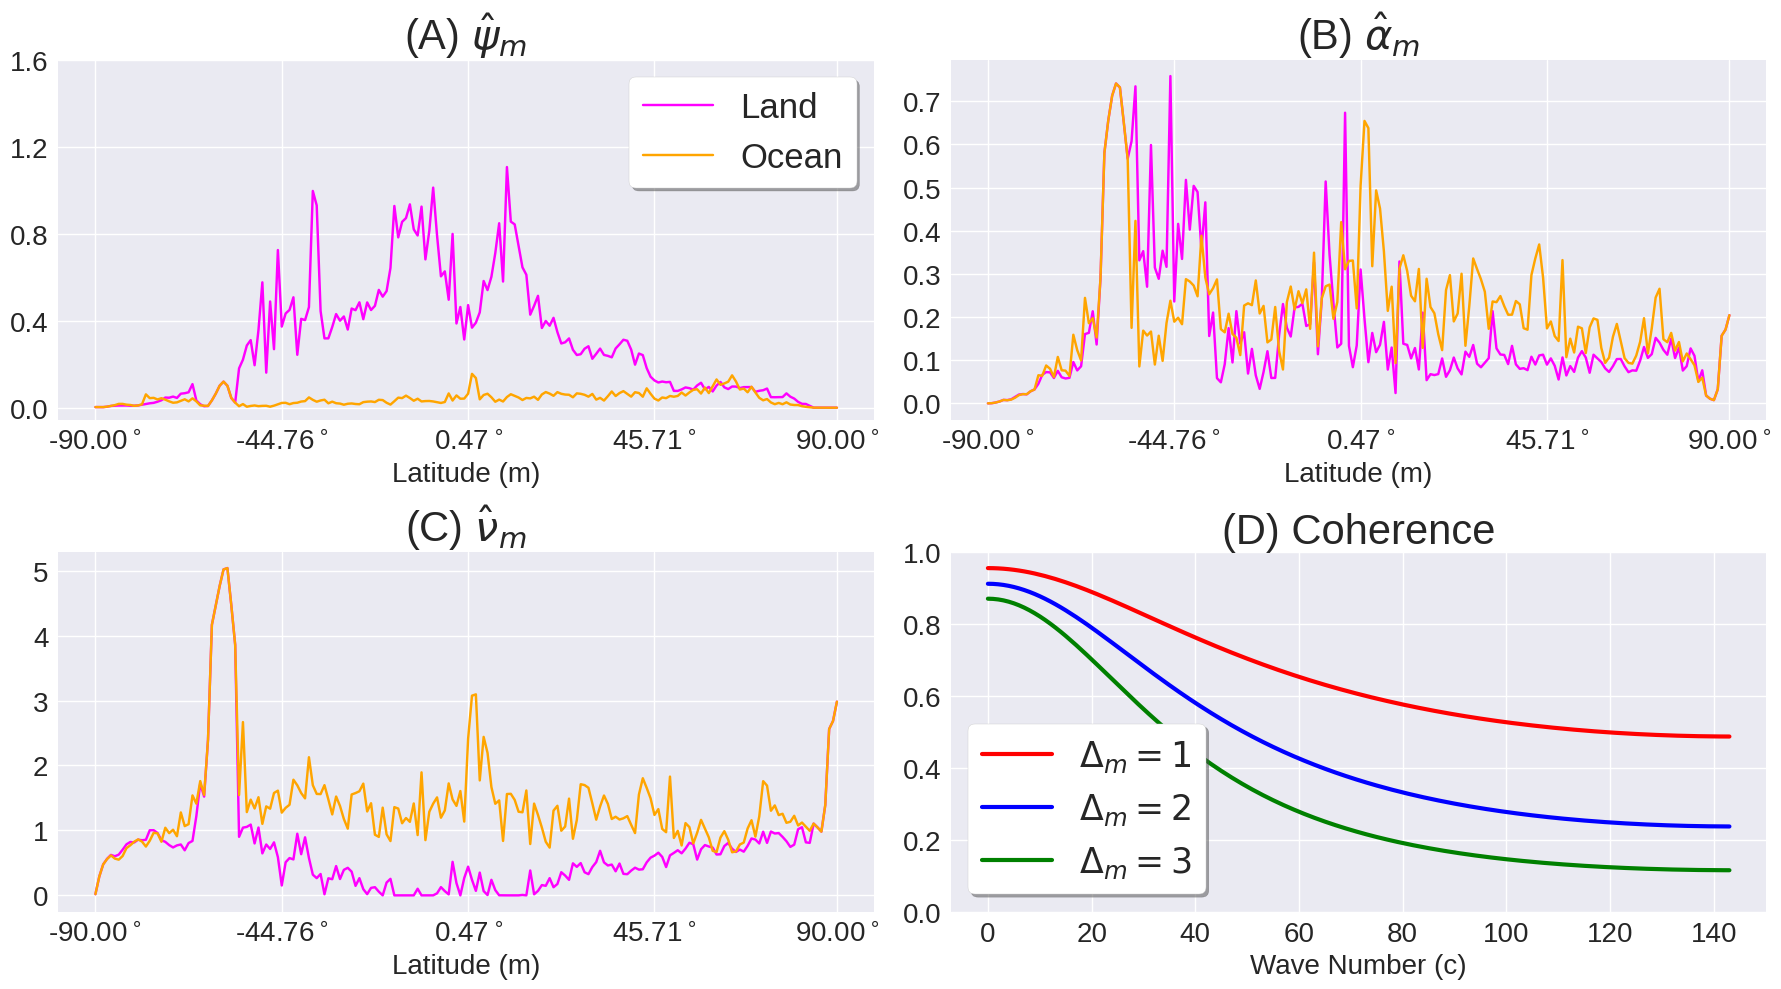

In [11]:
import matplotlib
matplotlib.style.use('seaborn')

plt.figure(figsize = (18,10))
plt.subplot(221)

plt.plot(psiLand, label = 'Land', color = 'magenta')
plt.plot(psiOcean, label = 'Ocean', color = 'orange')
plt.xlabel('Latitude (m)', fontsize = 20)
plt.xticks([*range(0,192,48),191], ['{:.2f}$^\circ$'.format(x) for x in lat[[*range(0,192,48),191]]], 
           fontsize = 20)
plt.yticks(np.arange(0,2,0.4), fontsize = 20)
plt.legend(fontsize = 25, frameon = True, facecolor = 'white', 
                 shadow = True, fancybox = True)
plt.title(r'(A) $\hat\psi_{m}$', fontsize = 30)

plt.subplot(222)

plt.plot(alphaLand, label = 'Land', color = 'magenta')
plt.plot(alphaOcean, label = 'Ocean', color = 'orange')
plt.xlabel('Latitude (m)', fontsize = 20)
plt.xticks([*range(0,192,48),191], ['{:.2f}$^\circ$'.format(x) for x in lat[[*range(0,192,48),191]]], 
           fontsize = 20)
plt.yticks(fontsize = 20)

plt.title(r'(B) $\hat\alpha_{m}$', fontsize = 30)

plt.subplot(223)

plt.plot(nuLand, label = 'Land', color = 'magenta')
plt.plot(nuOcean, label = 'Ocean', color = 'orange')
plt.xlabel('Latitude (m)', fontsize = 20)
plt.xticks([*range(0,192,48),191], ['{:.2f}$^\circ$'.format(x) for x in lat[[*range(0,192,48),191]]], 
           fontsize = 20)
plt.yticks(fontsize = 20)
plt.title(r'(C) $\hat\nu_{m}$', fontsize = 30)

plt.subplot(224)
plt.plot(get_coherence(xi, kappa, 1)[:int(N//2)], color = 'red',
         label = f'$\Delta_m=1$', linewidth = 3)
plt.plot(get_coherence(xi, kappa, 2)[:int(N//2)], color = 'blue',
         label = f'$\Delta_m=2$', linewidth = 3)
plt.plot(get_coherence(xi, kappa, 3)[:int(N//2)], color = 'green',
         label = f'$\Delta_m=3$', linewidth = 3)
plt.xlabel('Wave Number (c)', fontsize = 20)
plt.title('(D) Coherence', fontsize = 30)

plt.ylim(0,1)

plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.legend(fontsize = 25, frameon = True, facecolor = 'white', 
                 shadow = True, fancybox = True)

plt.tight_layout()

plt.savefig('SF12-grid-lo-lon-par.pdf', bbox_inches = 'tight')

In [12]:
m = 83
sample1 = eta[:,:,m].reshape(-1,N)
sample2 = eta[:,:,m,[*np.arange(1,N),0]].reshape(-1,N)
nonstationaryEmp = np.array([np.cov(sample1[:,x], sample2[:,x])[0,1] for x in range(N)])

fit = np.zeros(N)
for n in range(N):
    if landFlag[m,n]:
        tmp = psiLand[m] / np.power((alphaLand[m]*alphaLand[m] + 4*np.sin(omega/2)**2), nuLand[m]+0.5)
    else:
        tmp = psiOcean[m] / np.power((alphaOcean[m]*alphaOcean[m] + 4*np.sin(omega/2)**2), nuOcean[m]+0.5)
        
    fit[n] = (np.real(np.fft.ifft(tmp)))[1]

tmp = psi[m] / np.power((alpha[m]**2 + 4*np.sin(omega/2)**2), nu[m]+0.5)
axial = np.repeat(np.real(np.fft.ifft(tmp))[1],N)

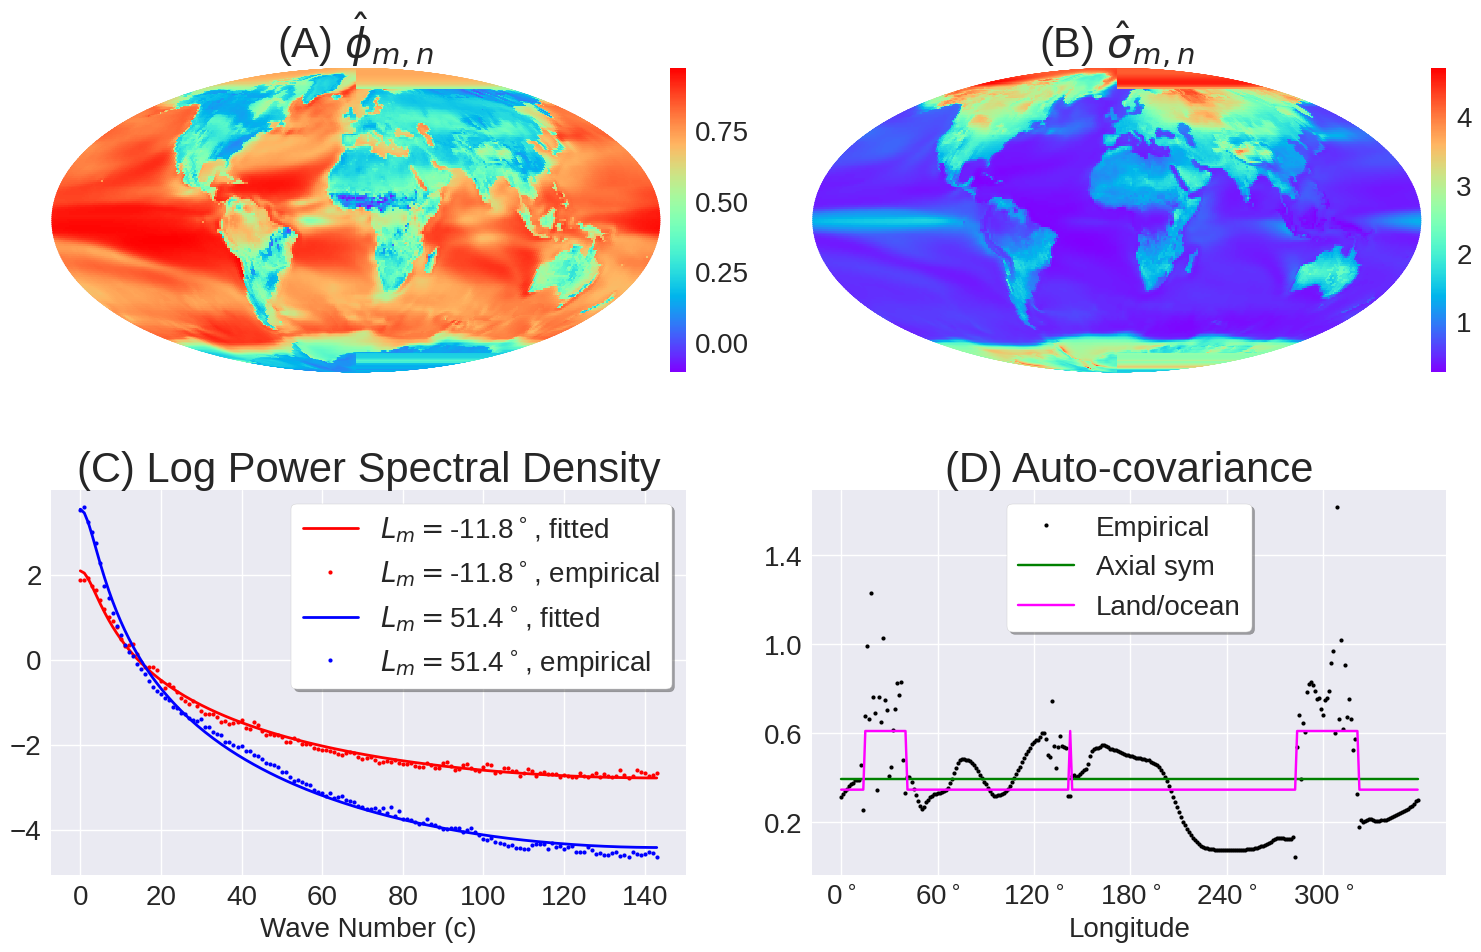

In [13]:
resolution = 1
cm = plt.cm.rainbow
gridColor = 'black'

fig = plt.figure(figsize = (18,11))
ax = fig.add_subplot(2,2,1, projection=mollweide)

ax.coastlines()
surface = ax.pcolormesh(lon[::resolution], lat[::resolution], phi[::resolution,::resolution], 
              transform=ccrs.PlateCarree(),cmap = cm)

plt.title('(A) $\hat\phi_{m,n}$', fontsize = 30)

divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="2.5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(cax)
cbar = fig.colorbar(surface, cax=cax)
cbar.ax.tick_params(labelsize=20)


ax = fig.add_subplot(2,2,2, projection=mollweide)

ax.coastlines()
surface = ax.pcolormesh(lon[::resolution], lat[::resolution], sigma[::resolution,::resolution], 
              transform=ccrs.PlateCarree(),cmap = cm)

plt.title('(B) $\hat\sigma_{m,n}$', fontsize = 30)

divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="2.5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(cax)
cbar = fig.colorbar(surface, cax=cax)
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(2,2,3)
show = 83
emp = np.zeros(N//2)
for time in range(T):
    for r in range(R):
        emp += (np.abs(np.fft.fft(eta[r,time,show]))[:int(N//2)])**2

plt.plot(np.log(get_marginal_power_spectral_model4(psi[show], alpha[show], nu[show])[:int(N//2)]), color = 'red',
         label = f'$L_m=${np.round(lat[show],1)}$^\circ$, fitted', linewidth = 2)
plt.plot(np.log(emp/N/T/R),'.', markersize = 6, 
         label = f'$L_m=${np.round(lat[show],1)}$^\circ$, empirical', color = 'red')

show = 150
emp = np.zeros(N//2)
for time in range(T):
    for r in range(R):
        emp += (np.abs(np.fft.fft(eta[r,time,show]))[:int(N//2)])**2
        
plt.plot(np.log(get_marginal_power_spectral_model4(psi[show], alpha[show], nu[show])[:int(N//2)]), color = 'blue',
         label = f'$L_m=${np.round(lat[show],1)}$^\circ$, fitted', linewidth = 2)
plt.plot(np.log(emp/N/T/R),'.',  markersize = 6, 
         label = f'$L_m=${np.round(lat[show],1)}$^\circ$, empirical', color = 'blue')

plt.legend(fontsize = 20, frameon = True, facecolor = 'white', shadow = True, fancybox = True)

plt.xlabel('Wave Number (c)', fontsize = 20)

plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)

plt.title('(C) Log Power Spectral Density', fontsize = 30)


ax = fig.add_subplot(2,2,4)

plt.plot((nonstationaryEmp),'k.', label = 'Empirical', markersize = 6)
plt.plot(axial, color = 'green', label = 'Axial sym')
plt.plot((fit), color = 'magenta', label = 'Land/ocean')
plt.xticks(range(0,N,48),['{}$^\circ$'.format(int(x)) for x in lon[::48]], fontsize = 20);
plt.yticks(np.arange(0.2,1.8,0.4),fontsize = 20)
plt.xlabel('Longitude', fontsize = 20)
plt.legend(fontsize = 20, frameon = True, facecolor = 'white', shadow = True, fancybox = True)

plt.title('(D) Auto-covariance', fontsize = 30)

plt.savefig('F5-gridded-monthly.png', dpi = 150, bbox_inches='tight')